<a href="https://colab.research.google.com/github/RL-Starterpack/rl-starterpack/blob/main/exercises/AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RL Tutorial - **Bandits Exercise**


## Setup

In [ ]:
#@title Run this cell to clone the RL tutorial repository and install it
try:
  import rl_starterpack
  print('RL-Starterpack repo succesfully installed!')
except ImportError:
  print('Cloning RL-Starterpack package...')

  # !git clone https://github.com/RL-Starterpack/rl-starterpack.git
  print('Installing RL-StarterPack package...')
  !pip install -e rl-starterpack[full] &> /dev/null
  print('\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('Please restart the runtime to use the newly installed package!')
  print('Runtime > Restart Runtime')
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

In [1]:
from typing import List, Optional, Tuple, Union
from IPython.display import Markdown as md
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from functools import partial
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
sns.set()
%matplotlib inline

In [2]:
from rl_starterpack import MultiArmedBandit, BanditExperiment, average_runs

As a first step, let's do some experimentation setup. The crucial thing we need is a **Multi-Armed Bandit test bed**. The test bed is the object where we define the arms, the reward distributions for each arm and the operation of drawing an arm and returning the ensuing reward.

We will provide some parameters to play with. Specifically, we can change the number of arms and the parameters of the distribution from which the mean reward for each arm is sampled.

We will also define the sampling functions that specify how the mean rewards for each arm is assigned and how the observed rewards are randomly sampled.

In [3]:
# PARAMETERS
NUM_ARMS = 10               # number of arms in the test bed
REWARD_MEAN = 1             # mean of normal distribution from which mean reward of each arm will be drawn
REWARD_STD = 1              # std of normal distribution from which mean reward of each arm will be drawn
                            # we will keep the std fixed throughout

In [4]:
# Gaussian samplers
def gaussian_mean_sampler(reward_mean: float = REWARD_MEAN, reward_std: float = REWARD_STD, size: int = 1):
    return np.random.normal(loc=reward_mean, scale=reward_std, size=size)


def gaussian_reward_sampler(mu: float, reward_std: float = REWARD_STD, size: int = 1):
    reward = np.random.normal(loc=mu, scale=reward_std, size=size)
    if size == 1:
        return reward[0]
    return reward

### The MultiArmedBandit

The MultiArmedBandit object takes as parameters:

1. the number of arms
2. the function from which to sample the mean reward of each arm
3. the function to sample the observed rewards for each arm given its mean reward

The assigned reward distributions for the arms can be visualised with `MultiArmedBandit.visualise()`. Keep a note of the arm with the highest actual mean reward. Ideally, we would like each of the policies we implement to find this optimal arm.

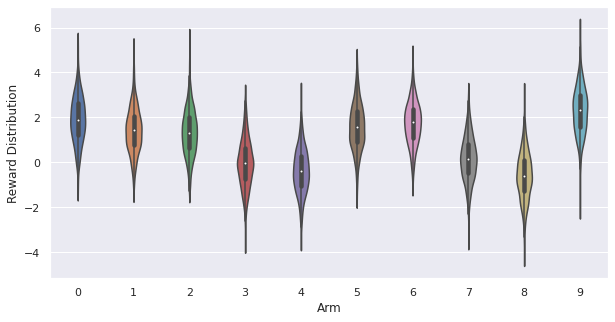

In the testbed above, the **optimal arm** is arm **9**

In [5]:
multi_armed_bandit = MultiArmedBandit(num_arms=NUM_ARMS, arm_mean_sampler=gaussian_mean_sampler, arm_reward_sampler=gaussian_reward_sampler)
multi_armed_bandit.visualise()

md(f'In the testbed above, the **optimal arm** is arm **{multi_armed_bandit.mean_rewards.argmax()}**')

## The EXPERIMENT

The `BanditExperiment` object will help us run and accumulate the results of a sequence of arm pulls of a multi armed bandit. We will provide a `MultiArmedBandit` and a `policy` to the `experiment`. We will pull arms from the testbed using the policy for a fixed number of **timesteps**. After that we can visualise the results. Specifically, we will look at the profile of rewards received over time according to the policy, the distribution of rewards observed from each arm and the number of times each arm was pulled in the experiment. To quantify the quality of the policies we implement we will also look at the optimal arm found by each policy and the average reward accumulated over the experiment's timesteps.

To make sure our policies actually perform as expected over varying conditions, we will make multiple experiments over different multi armed bandits and average the results to compare the effect of different parameter setting. For this, we have a function `average_runs` which takes the following parameters:

1. policy function to pick an arm
2. number of timesteps to run each experiment for
3. number of separate experiments to run
4. parameters for the experiment or policy to compare

## POLICIES

### Explore Then Commit
In this policy we systematically explore each arm for a fixed number of rounds. After that, we exploit the best known arm for the remaining timesteps.

The hyperparameter for this policy will be the **number of rounds** for which we explore the arms. We can set this value to be anything between `1` (explore the arms for one round only) and `horizon / number_of_arms` (keep exploring the arms throughout).

Set the hyperparameter and implement the policy in the following cell.

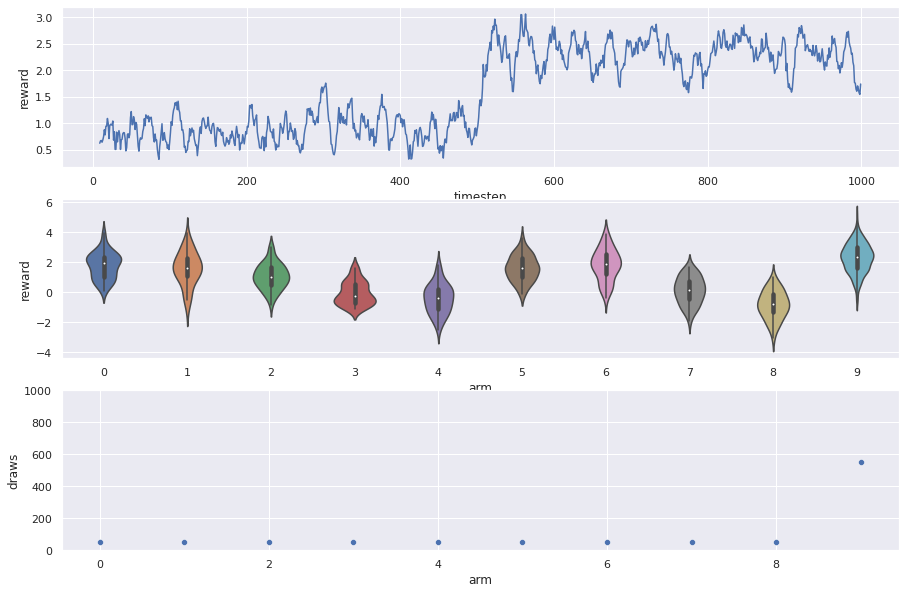


Optimal arm found with **ETC** is **9**

Number of times each arm was **pulled**: {0: 50, 1: 50, 2: 50, 3: 50, 4: 50, 5: 50, 6: 50, 7: 50, 8: 50, 9: 550}

**Average reward** collected is **1.6000913233367056**


In [6]:
# Implement policy here
num_rounds = 50

def explore_then_commit(expected_rewards: List[float], num_draws: List[int], num_rounds: int=num_rounds) -> int:
    num_arms = len(expected_rewards)
    total_draws = sum(num_draws)
    if total_draws < num_rounds * num_arms:
        return total_draws % num_arms

    max_reward_arms = np.where(expected_rewards == max(expected_rewards))[0]
    return np.random.choice(max_reward_arms)

# run experiment with policy
experiment = BanditExperiment(multi_armed_bandit, explore_then_commit)
experiment.run(num_steps=1000)
experiment.visualise_results()

md(f'''
Optimal arm found with **ETC** is **{experiment.expected_rewards.argmax()}**

Number of times each arm was **pulled**: {dict(zip(range(len(experiment.num_draws)), experiment.num_draws))}

**Average reward** collected is **{np.array(experiment.observed_rewards).mean()}**
''')

Now let's compare the policy performance for different values of `num_rounds`, averaged over **200** separate experiments.

100%|██████████| 200/200 [00:04<00:00, 40.16it/s]


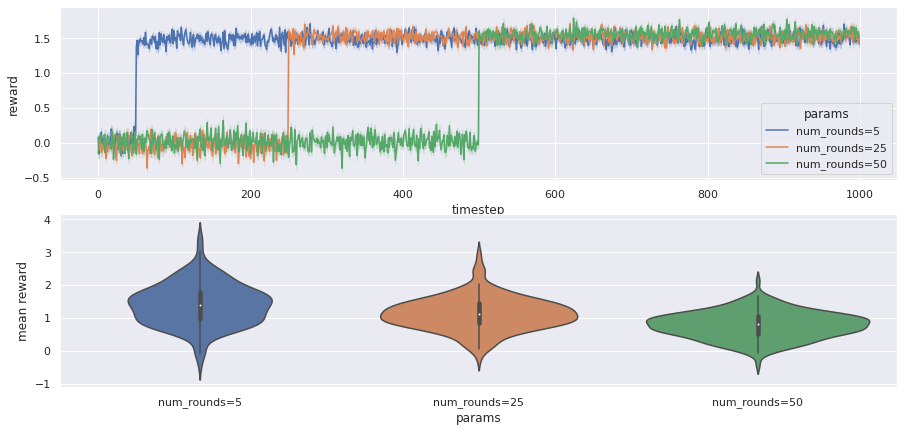

In [7]:
average_runs(explore_then_commit, repeats=200, num_rounds=[5, 25, 50])

### $\epsilon$-greedy
In this policy, we either uniformly choose a random arm with a probability $ \epsilon \in (0,1)$ or choose the arm with best known expected reward.

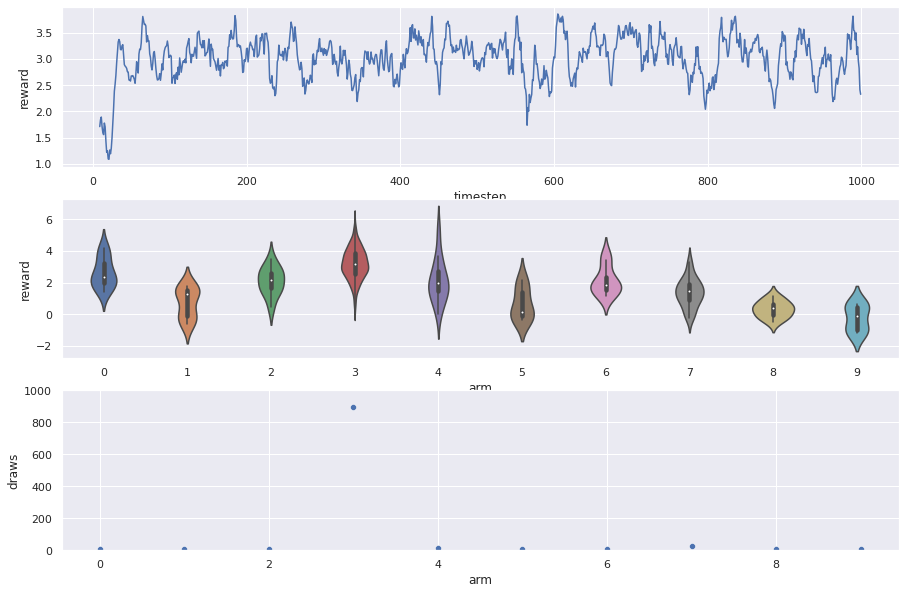


Optimal arm found with **$\epsilon$-greedy** is **3**

Number of times each arm was **pulled**: {0: 10, 1: 9, 2: 10, 3: 897, 4: 14, 5: 7, 6: 9, 7: 28, 8: 10, 9: 6}

**Average reward** collected is **3.006915680711776**


In [7]:
epsilon = 0.1

# IMPLEMENT policy here
def epsilon_greedy(expected_rewards: List[float], num_draws: List[int], epsilon: float=epsilon) -> int:
    if np.random.uniform() <= epsilon:
        choices = range(len(expected_rewards))
    else:
        choices = np.where(expected_rewards == max(expected_rewards))[0]
        
    arm = np.random.choice(choices)
    return arm

# run experiment with policy
experiment = BanditExperiment(multi_armed_bandit, epsilon_greedy)
experiment.run(num_steps=1000)
experiment.visualise_results()

md(f'''
Optimal arm found with **$\epsilon$-greedy** is **{experiment.expected_rewards.argmax()}**

Number of times each arm was **pulled**: {dict(zip(range(len(experiment.num_draws)), experiment.num_draws))}

**Average reward** collected is **{np.array(experiment.observed_rewards).mean()}**
''')

100%|██████████| 200/200 [00:06<00:00, 30.10it/s]


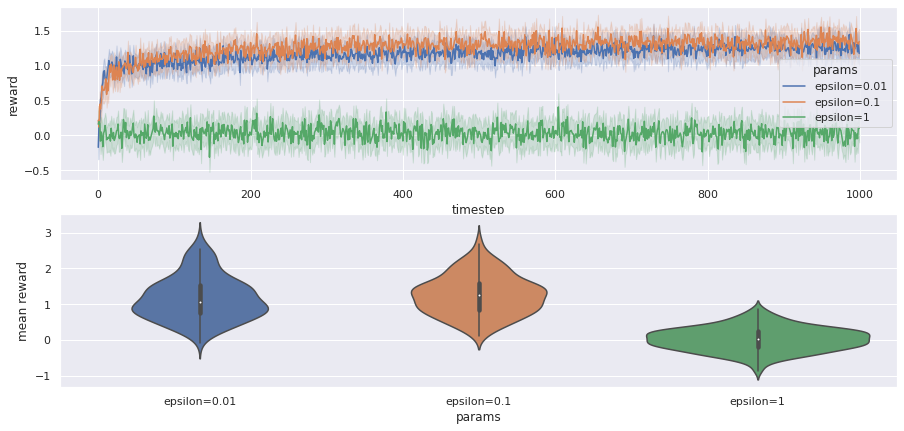

In [9]:
average_runs(epsilon_greedy, epsilon=[0.01, 0.1, 1])

### Optimistic Initial Values (**OIV**)
In this policy, we set the initial expected reward values to a **wildly optimistic high number**. The reasoning is, as we update the high initial expected rewards with the observed rewards, they will tend to lower values. In this setting, if we choose the arm with the highest expected reward, we will end up exploring the arms more until the arm with the best reward is found.

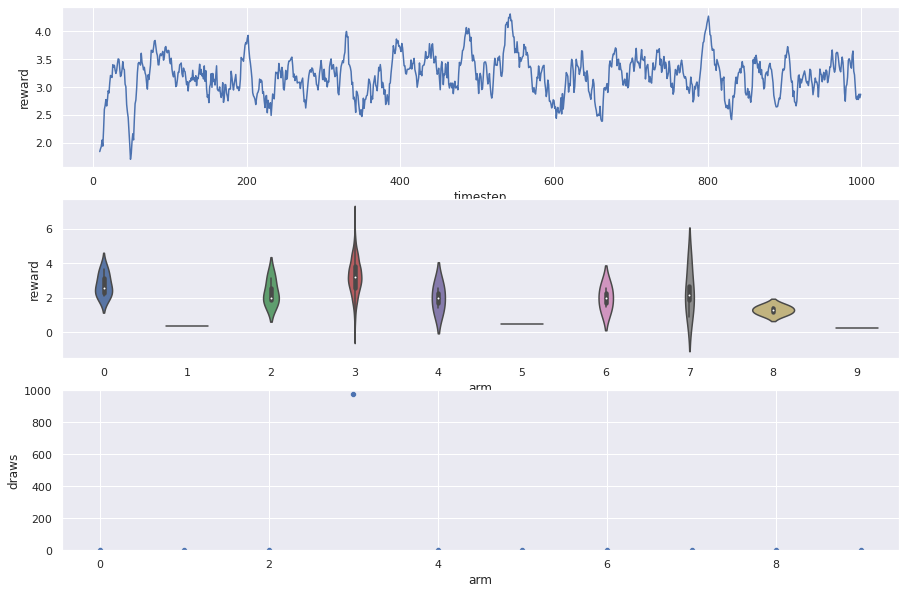


Optimal arm found with **OIV** is **3**

Number of times each arm was **pulled**: {0: 5, 1: 1, 2: 3, 3: 979, 4: 2, 5: 1, 6: 2, 7: 4, 8: 2, 9: 1}

**Average reward** collected is **3.1964465401010544**


In [8]:
optimistic_initial_reward = 5

# IMPLEMENT policy here
def optimistic_initial_values(expected_rewards: List[float], num_draws: int, **kwargs) -> int:
    max_reward_arms = np.where(expected_rewards == max(expected_rewards))[0]
    return np.random.choice(max_reward_arms)

# run experiment with policy
experiment = BanditExperiment(multi_armed_bandit, optimistic_initial_values, init_rewards=optimistic_initial_reward)
experiment.run(num_steps=1000)
experiment.visualise_results()

md(f'''
Optimal arm found with **OIV** is **{experiment.expected_rewards.argmax()}**

Number of times each arm was **pulled**: {dict(zip(range(len(experiment.num_draws)), experiment.num_draws))}

**Average reward** collected is **{np.array(experiment.observed_rewards).mean()}**
''')

100%|██████████| 200/200 [00:06<00:00, 30.11it/s]


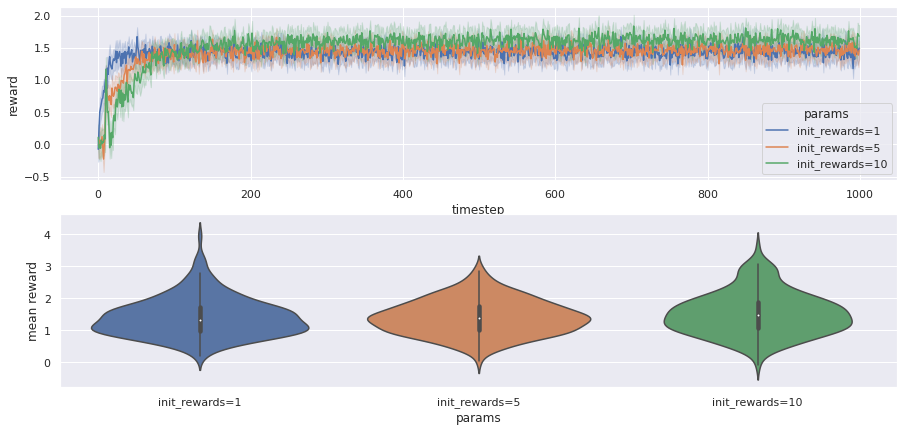

In [11]:
average_runs(optimistic_initial_values, init_rewards=[1, 5, 10])

### Upper Confidence Bound (**UCB**)
In this policy, we use the number of times each arm has been drawn to compute a confidence interval for the expected reward for each arm. At each step we select the arm with the highest upper bound for the confidence interval. The **weight given to uncertainty term**, $c \in (0, 1]$ is a hyperparameter in this case.

This method is the most popular policy used for bandits. The uncertainty bounds aid is exploration in the initial stages, but stops it as soon as soon as the optimal arm is found.

One thing to keep in mind is UCB can only be applied after each arm has been tried at least once. This is to ensure that uncertainty for each arm can be computed. For this we add another hyperparameter for the **number of tries**. Until each arm has been pulled this minimum number of times, we randomly select one of the arms that has not yet been pulled enough times.

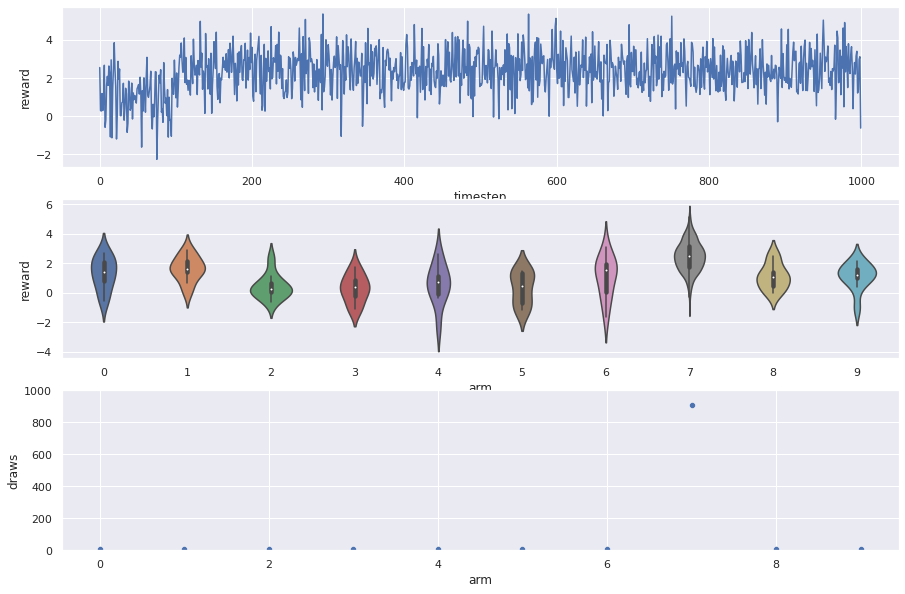


Optimal arm found with **UCB** is **7**

Number of times each arm was **pulled**: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 910, 8: 10, 9: 10}

**Average reward** collected is **2.3221800848950984**


In [12]:
# IMPLEMENT policy here
WEIGHT = 0.5
NUM_TRIES_PER_ARM = 10

def upper_confidence_bound(expected_rewards: List[float],
                        num_draws: List[int],
                        weight: float=WEIGHT,
                        num_tries_per_arm: int=NUM_TRIES_PER_ARM) -> int:
    if any(num_draws < num_tries_per_arm):
        unpulled_arms = np.where(num_draws < num_tries_per_arm)[0]
        return np.random.choice(unpulled_arms)

    total_draws = sum(num_draws)
    num_arms = len(expected_rewards)
    uncertainty = np.sqrt(np.log(total_draws + num_arms) / (num_draws + num_arms))
    ucb = expected_rewards + weight * uncertainty

    max_reward_arms = np.where(ucb == max(ucb))[0]
    return np.random.choice(max_reward_arms)

# run experiment with policy
experiment = BanditExperiment(multi_armed_bandit, upper_confidence_bound)
experiment.run(num_steps=1000)
experiment.visualise_results()

md(f'''
Optimal arm found with **UCB** is **{experiment.expected_rewards.argmax()}**

Number of times each arm was **pulled**: {dict(zip(range(len(experiment.num_draws)), experiment.num_draws))}

**Average reward** collected is **{np.array(experiment.observed_rewards).mean()}**
''')

100%|██████████| 200/200 [00:09<00:00, 21.19it/s]


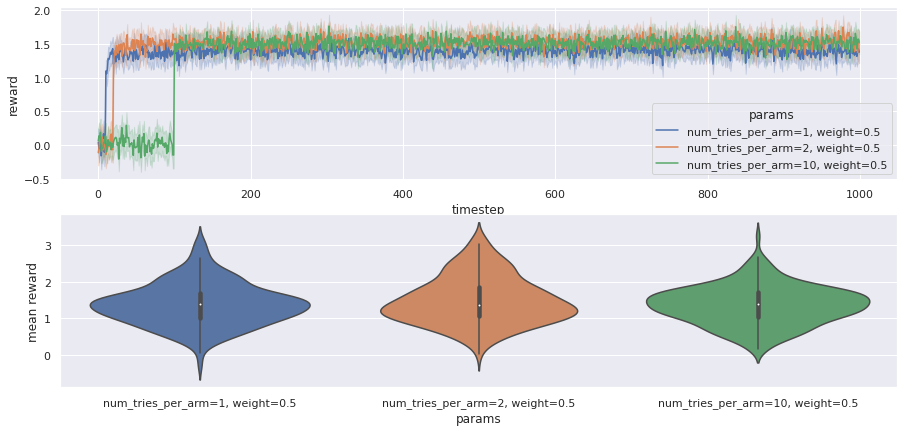

In [13]:
average_runs(upper_confidence_bound, weight=0.5, num_tries_per_arm=[1, 2, 10])

## OPTIONAL

### Thompson Sampling
In this policy, we are going to put a **prior** on each arm and learn the distribution of the rewards for each pulled arm directly.

To keep things simple, we will look at a Beta/Bernoulli example. For that, we will make a few modifications to our setup.

We will start with redifining our mean sampling functions and using them to create a Bernoulli testbed.

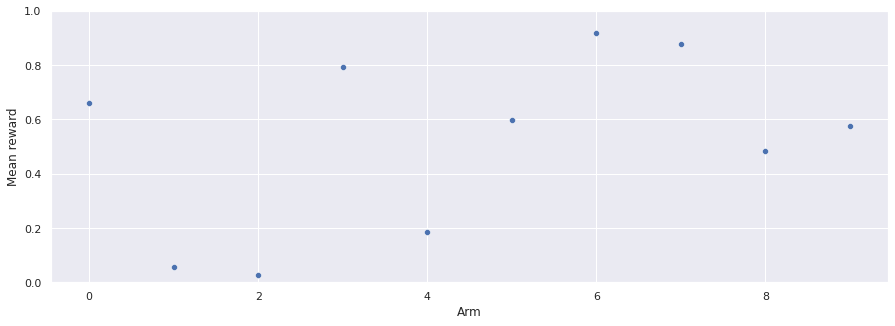

Arm with **maximum mean reward** is arm **6**

In [14]:
def uniform_mean_sampler(size: int=1) -> float:
    return np.random.uniform(size=size)

def bernoulli_reward_sampler(p: float, size: int=1) -> float:
    reward = np.random.binomial(n=1, p=p, size=size)
    if size == 1:
        return reward[0]
    return reward

bayesian_bandit = MultiArmedBandit(num_arms=NUM_ARMS, arm_mean_sampler=uniform_mean_sampler, arm_reward_sampler=bernoulli_reward_sampler)
sns.scatterplot(x=range(NUM_ARMS), y=bayesian_bandit.mean_rewards, ax=plt.subplots(figsize=(15, 5))[1])
plt.ylim(0, 1)
plt.xlabel('Arm')
plt.ylabel('Mean reward')
plt.show()

md(f"Arm with **maximum mean reward** is arm **{bayesian_bandit.mean_rewards.argmax()}**")


Now let's redefine how our experiments are conducted for the Beta/Bernoulli use case.

In [15]:
# set initial Beta prior parameters
alpha = 0
beta = 0

class ThompsonExperiment(BanditExperiment):
    
    def _init_fields(self) -> None:
        self.observed_rewards = []
        # alphas - first column, betas - second column
        self.beta_params = np.tile([alpha, beta], self.multi_armed_bandit.num_arms).reshape(self.multi_armed_bandit.num_arms, 2)
        self.observed_draws = []
        self.num_draws = np.zeros(self.multi_armed_bandit.num_arms, dtype=np.int32)
        self.total_draws = 0

    def step(self) -> Tuple[int, float]:
        chosen_arm = self.policy(self.beta_params)
        reward = self.multi_armed_bandit.draw_arm(chosen_arm)

        self.total_draws += 1
        self.observed_draws.append(chosen_arm)
        self.num_draws[chosen_arm] += 1
        self.observed_rewards.append(reward)
        if reward == 1:
            self.beta_params[chosen_arm, 0] += 1
        else:
            self.beta_params[chosen_arm, 1] += 1

        return chosen_arm, reward


Now let's implement the sampling policy. For Thompson sampling, we will use the prior parameters to sample expected rewards for each arm and select the arm with the highest sampled reward. Depending on the observed reward, we update the prior parameters for the respective arm.

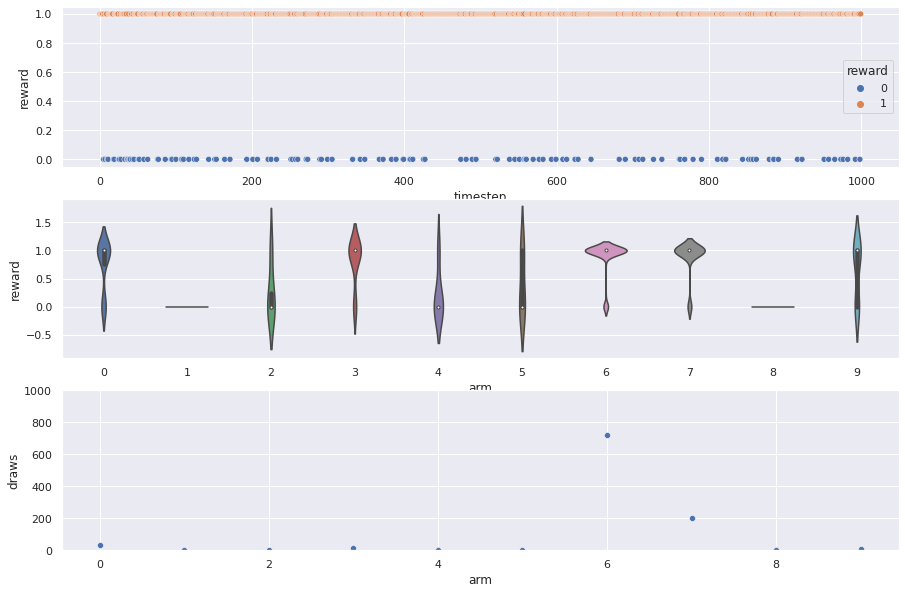


Optimal arm found with **Thompson sampling** is **6**

Number of times each arm was **pulled**: {0: 36, 1: 2, 2: 4, 3: 15, 4: 5, 5: 5, 6: 719, 7: 201, 8: 2, 9: 11}

**Average reward** collected is **0.877**


In [16]:
def beta_bernoulli_priors(beta_params: List[List[int]]) -> int:
    sampled_rewards = []
    for i in range(len(beta_params)):
        alpha, beta = beta_params[i]
        reward = scipy.stats.beta.rvs(alpha + 1, beta + 1)
        sampled_rewards.append(reward)

    max_reward_arms = np.where(np.array(sampled_rewards) == max(sampled_rewards))[0]
    return np.random.choice(max_reward_arms)

# run experiment with policy
experiment = ThompsonExperiment(bayesian_bandit, beta_bernoulli_priors)
experiment.run(num_steps=1000)
experiment.visualise_results(kind='scatter')

expected_means = np.array([scipy.stats.beta.mean(a + 1, b + 1) for a, b in experiment.beta_params])

md(f'''
Optimal arm found with **Thompson sampling** is **{expected_means.argmax()}**

Number of times each arm was **pulled**: {dict(zip(range(len(experiment.num_draws)), experiment.num_draws))}

**Average reward** collected is **{np.array(experiment.observed_rewards).mean()}**
''')